# **TikTok Project – Machine Learning (part 5)**

The project’s exploratory and cleaning phases are complete, and both the Lead Data Scientist and the Project Manager have asked us to tackle the final, and most critical, task: build a machine‑learning model that automatically flags a video as either a claim or an opinion. A robust classifier will let TikTok triage user reports faster and shrink the moderation backlog.

**The purpose**: Train a model that labels each video claim vs opinion by leveraging content attributes, engagement metrics, and textual features.

**The goal**: Build a machine learning classifier able to classify with high accuracy a video as claim or opinion to help TikTok content moderators prioritzing their efforts.

To start, we import necessary libraries then, load the dataset into a dataframe. 

In [50]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")
# Display the first few rows of the dataset
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Clean missing values as done in the previous part:

In [3]:
# Check for missing values
missing_values = data.isna().sum()
# Print number of missing values in each column
print("Missing values in each column (initially):")
print(missing_values)
# Drop rows with missing values
data = data.dropna(axis=0)
missing_values_after = data.isna().sum()
# Print number of missing values in each column
print("Missing values in each column (after cleaning):")
print(missing_values_after)
# Check for duplicates
print("Number of duplicate rows in the dataset:")
data.duplicated().sum()

Missing values in each column (initially):
#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64
Missing values in each column (after cleaning):
#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64
Number of duplicate rows in the dataset:


np.int64(0)

Let's now check for class balance:

In [4]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

... approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

Let's now do some feature engineering:

In [6]:
# Engineer simple transcription length feature as done before
data['text_length'] = data['video_transcription_text'].str.len()
# Display the first few rows of the dataset with the new feature
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Let's visualize the distribution of the new feature `text_length` for claims and opinions:

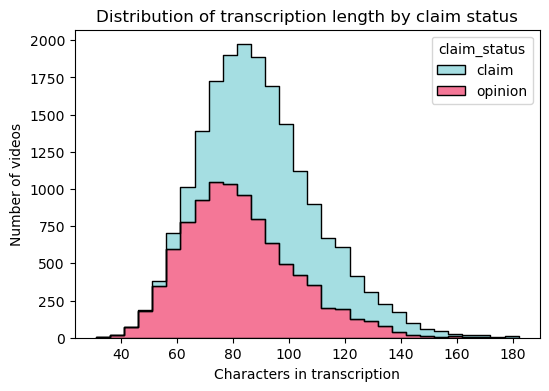

In [ ]:
# Define TikTok brand colours for the two claim‑status classes
tiktok_palette_claims = {
    'claim':   '#69C9D0',
    'opinion': '#EE1D52'
}
# Visualise the distribution of transcription length by claim status
plt.figure(figsize=(6, 4))
sns.histplot(
    data=data,
    x='text_length',
    hue='claim_status',
    bins=30,
    element='step',
    stat='count',
    multiple='stack',
    palette=tiktok_palette_claims,
    alpha=0.6
)
plt.title('Distribution of transcription length by claim status')
plt.xlabel('Characters in transcription')
plt.ylabel('Number of videos')
plt.show()

... letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters (about 15 more on average).

Clean up the dataframe before starting to build the model:

In [ ]:
# Copy the dataset to a new variable for further model training and testing
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
# Display the first few rows of the dataset after encoding
X.head()

C:\Users\matteucc\AppData\Local\Temp\ipykernel_33616\759898074.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


Isolate features from target variable:

In [ ]:
# Isolate target variable
y = X['claim_status']
# Isolate features
X = X.drop(['claim_status'], axis=1)
# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


Let's split data into training and testing sets, 80/20. Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [16]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)
# Get shape of each training, validation, and testing set
print("Shape of training, validation, and testing sets:")
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

Shape of training, validation, and testing sets:


((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

Let's do some more feature engineering, this time NLP-based (bi‑/tri‑grams count feature extraction).
To give the model a lightweight taste of the actual transcript, we turn each `video_transcription_text` into a bag‑of‑words representation:

* **Tokenisation**: split the text into 2‑ and 3‑word n‑grams.  
* **Vocabulary pruning**: keep the 15 most frequent n‑grams in the *training* corpus (stop‑words removed).  
* **Vectorisation**: count how often each retained n‑gram appears in every video; the resulting 15 counts become additional numeric features.

This keeps the feature space compact while still surfacing common formulaic phrases that differentiate *claims* from *opinions*. Let's start setting up the CountVectorizer:


In [17]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [18]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(11450, 15))

Augment the training set:

In [19]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)
# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Augment the validation set:

In [27]:
# Extract numerical features from `video_transcription_text` in the validation set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(3817, 15))

In [24]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)
# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


Augment the test set:

In [26]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()
# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Finally we are ready to train our first model on the clean, augmented dataset we prepared. Let's start with a random forest classifier (we will use cross-validation to tune the hyperparameters and select the model that performs best on recall):

In [28]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)
# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }
# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']
# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [29]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: total: 3min 13s
Wall time: 3min 13s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [30]:
# Examine best recall score
rf_cv.best_score_

np.float64(0.9948228253467271)

In [31]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

An important sanity-check at this point is: "is the tuned model simply shouting “claim” every time?"
After the `GridSearchCV`, we can verify its cross‑validated precision:

In [32]:
# Access the GridSearch results and convert it to a pandas df
rf_results_df = pd.DataFrame(rf_cv.cv_results_)
# Examine the GridSearch results df at column `mean_test_precision` in the best index
rf_results_df['mean_test_precision'][rf_cv.best_index_]

np.float64(0.9994806638131711)

... this model performs exceptionally well, with an average recall score of 0.999 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

Now let's try instead with an XGBoost classifier (we will use cross-validation to tune the hyperparameters and select the model that performs best on recall):

In [33]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)
# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }
# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']
# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [34]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 9min 53s
Wall time: 36.5 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [35]:
xgb_cv.best_score_

np.float64(0.9898176171763818)

In [36]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

Repeat the steps used for random forest to examine the precision score of the best model identified in the grid search.

In [37]:
# Access the GridSearch results and convert it to a pandas df
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)
# Examine the GridSearch results df at column `mean_test_precision` in the best index
xgb_results_df['mean_test_precision'][xgb_cv.best_index_]

np.float64(0.9989540885869099)

... this model also performs exceptionally well. Although both its precision and recall scores are very slightly lower than the random forest model's.

Last step will be evaluating the trained models against validation data. Let's start with the random forest one:

In [38]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

In [ ]:
# Display the predictions on the validation set after converting to dataframe
y_pred_df = pd.DataFrame(y_pred, columns=['claim_status_pred'])
# Display first few rows of the predictions dataframe
y_pred_df.head(10)

,claim_status
0,1
1,0
2,1
3,1
4,1
5,0
6,0
7,0
8,1
9,0


In [47]:
# Display the values of the validation set after converting to dataframe 
y_val = pd.DataFrame(y_val, columns=['claim_status'])
# Display first few rows of the validation set dataframe
y_val.head(10)

,claim_status
5846,1
12058,0
2975,1
8432,1
6863,1
14032,0
17834,0
9716,0
3854,1
15242,0


Create a confusion matrix to visualize the results of the classification model and output a classification report:

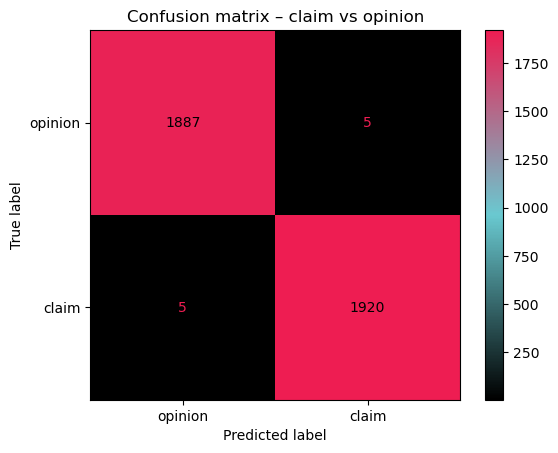

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [52]:
# TikTok‑style 3‑colour map: black → cyan → magenta
tiktok_cmap = LinearSegmentedColormap.from_list(
    'black_cyan_magenta',
    ['black', '#69C9D0', '#EE1D52']
)
# compute confusion matrix on the validation set
cm = confusion_matrix(y_val, y_pred)
# plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['opinion', 'claim']   # adjust order if 0/1 are flipped
)
disp.plot(cmap=tiktok_cmap)
plt.title('Confusion matrix – claim vs opinion')
plt.show()
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

Now let's examine in the same way the XGBoost model...

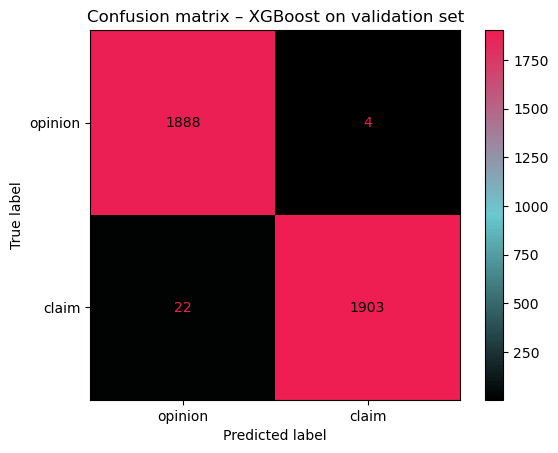

In [53]:
# define TikTok‑style 3‑node colormap: black → cyan → magenta
tiktok_cmap = LinearSegmentedColormap.from_list(
    'black_cyan_magenta',
    ['black', '#69C9D0', '#EE1D52']
)

# generate predictions on the validation set using the best XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

# compute and plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['opinion', 'claim']   # adjust if label encoding is reversed
)
disp.plot(cmap=tiktok_cmap)
plt.title('Confusion matrix – XGBoost on validation set')
plt.show()


Now let's inspect feature importance for the random forest model.

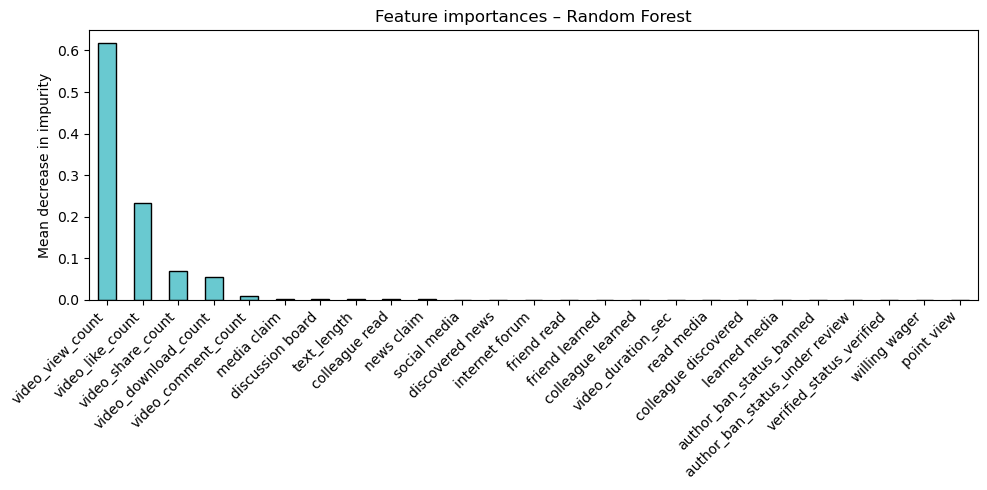

In [54]:
# Get feature importances from the best random forest model
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)
# Plot with TikTok cyan bars
fig, ax = plt.subplots(figsize=(10, 5))
rf_importances.sort_values(ascending=False).plot.bar(
    ax=ax,
    color='#69C9D0',
    edgecolor='black'
)
ax.set_title('Feature importances – Random Forest')
ax.set_ylabel('Mean decrease in impurity')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.show()

### **Conclusion and final takeaway for stakeholders ---**

Our goal was to build a model that classifies TikTok videos as **claims** or **opinions** based on their content, metadata, and transcription text. After cleaning, feature engineering, and model tuning, the final classifiers—particularly XGBoost and Random Forest—achieved strong performance, with **high precision and recall** for both classes on unseen validation data.

Questions and answers for communicating with stakeholders:

1. **Would I recommend using this model?**  
Yes. The model generalises well, achieves balanced performance across classes, and could assist TikTok in automating content triage—especially by identifying likely *claims* for priority moderation.

2. **What is the model learning?**  
The most informative features included basic engagement signals like **comment** and **share counts**, as well as high-frequency **bi-/tri-gram patterns** from the transcription text. These textual patterns likely capture common phrasings that distinguish claims from opinions.

3. **Could additional features improve it?**  
Yes. While the model performs already very well (enough for the initial buisness goal), performance and its stability over time in spite of changes in user behavior on the platform might benefit from:
   - semantic embeddings
   - sentiment scores
   - temporal features
   - author history

4. **What would help most?**  
Access to **user report data** (such as how often a video was flagged or keywords in the reports) would be invaluable for both training and downstream prioritisation.